# **PART I - DATA AND PRELEMINARY WORK**

In [39]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

DATA = Path("../data/ergast")

In [40]:
laps = pd.read_csv(DATA / "lap_times.csv")
pits = pd.read_csv(DATA / "pit_stops.csv")
races = pd.read_csv(DATA / "races.csv")
drivers = pd.read_csv(DATA / "drivers.csv")[["driverId", "surname"]]

In [41]:
YEAR, ROUND = 2023, 3
race_id = races.query("year==@YEAR and round==@ROUND").raceId.iloc[0]
print(f"Loaded race_id {race_id} for {YEAR} round {ROUND}")

Loaded race_id 1100 for 2023 round 3


In [42]:
race_laps = laps[laps.raceId == race_id].copy()
race_pits = pits[pits.raceId == race_id][["driverId", "lap"]]

In [43]:
#marking pit stops
race_laps = race_laps.merge(race_pits.assign(pit=1), on=["driverId", "lap"], how="left")
race_laps["pit"] = race_laps["pit"].fillna(0)

In [44]:
#building stint and tyre age
race_laps["stint"] = race_laps.groupby("driverId")["pit"].cumsum()
race_laps["tyre_age"] = race_laps.groupby(["driverId","stint"]).cumcount()

In [45]:
race_laps.head()

,raceId,driverId,lap,position,time,milliseconds,pit,stint,tyre_age
0,1100,847,1,1,1:37.854,97854,0.0,0.0,0
1,1100,847,2,1,2:13.298,133298,0.0,0.0,1
2,1100,847,3,1,2:12.017,132017,0.0,0.0,2
3,1100,847,4,1,1:23.134,83134,0.0,0.0,3
4,1100,847,5,1,1:23.134,83134,0.0,0.0,4


In [46]:
print(race_laps.columns.tolist())
print(drivers.columns.tolist())

['raceId', 'driverId', 'lap', 'position', 'time', 'milliseconds', 'pit', 'stint', 'tyre_age']
['driverId', 'surname']


In [47]:
#Merging race info with driver info
driver_info = drivers[["driverId", "surname"]]   

race_laps = race_laps.merge(driver_info, on="driverId", how="left")


In [48]:
race_laps[['driverId','surname']].head()

,driverId,surname
0,847,Russell
1,847,Russell
2,847,Russell
3,847,Russell
4,847,Russell


# **PART II - VERSTAPPEN**

In [49]:
ver = race_laps.query("surname == 'Verstappen'")

In [61]:
ver_clean = ver[(ver["pit"] == 0) & (ver['milliseconds'] < 120_000)].copy()

In [63]:
q1 = ver_clean['milliseconds'].quantile(0.25)
q3 = ver_clean['milliseconds'].quantile(0.75)
iqr = q3 - q1
upper = q3 + 1.5 * iqr
ver_race = ver_clean[ver_clean['milliseconds'] <= upper]

In [64]:
# X = Tyre Age; Y = Lap Time(s)
Xr = ver_race["tyre_age"].values.reshape(-1,1)
yr = ver_race["milliseconds"].values / 1000

In [66]:
model_r = LinearRegression().fit(Xr, yr)
slope_r = model_r.coef_[0]
print(f"Degradation rate (clean racing laps): {slope_r:.3f} s/lap")
intercept = model_c.intercept_

Degradation rate (clean racing laps): -0.053 s/lap


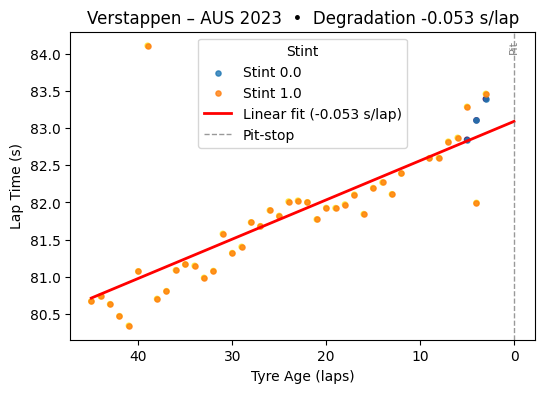

In [84]:
# Plotting 
fig, ax = plt.subplots(figsize=(6,4))
sc = ax.scatter(
    ver_race['tyre_age'],
    yr,
    c=ver_race['stint'],
    cmap='viridis',
    s=14,
    alpha=0.8,
    
)
for stint_id, grp in ver_race.groupby("stint"):
    ax.scatter(grp["tyre_age"], grp["milliseconds"]/1000,
               s=14, alpha=0.8,
               label=f"Stint {stint_id}")
ax.legend(title="Stint")
ax.set_xlabel("Tyre Age (laps)")        # ← x-axis label
ax.set_ylabel("Lap Time (s)")           # ← y-axis label
ax.set_title(f"Verstappen – AUS 2023  •  Degradation {slope:+.3f} s/lap")
ax.invert_xaxis()


# Regression Line
coef = np.polyfit(ver_race['tyre_age'], ver_race['milliseconds']/1000, 1)
px = np.arange(0, ver_race['tyre_age'].max() +1)
plt.plot(
    px,
    np.polyval(coef, px),
    color='red',
    lw=2,
    label=f"Linear fit ({coef[0]:+.3f} s/lap)"
)
plt.legend(title='Stint')

# Annotate pit-stops (stint boundaries)
for stint_id, grp in ver_clean.groupby("stint"):
    if stint_id == 0:
        continue                    
    ax.axvline(
        x=0,                         
        ls="--", lw=1,
        c="grey", alpha=0.8,
        label="Pit-stop" if stint_id == 1 else None
    )
    ax.text(
        0, ax.get_ylim()[1] - 0.1,   
        "Pit", rotation=90,
        va="top", ha="center",
        fontsize=8, color="grey"
    )

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title="Stint")

